# UBER H3

- [H3 at Uber Engineering](https://eng.uber.com/h3/)
- [H3 library main web site](https://h3geo.org/)
- [H3 Docs](https://h3geo.org/docs/)

## Use case

Main use case of H3 in Uber was discretization, bucketing/binning into same grids for data aggregation and unified analysis (https://h3geo.org/docs/highlights/aggregation/).

Analysis of location data, such as locations of cars in a city, can be done by bucketing locations ([Sahr et al., 2003](http://webpages.sou.edu/~sahrk/sqspc/pubs/gdggs03.pdf)). Using a regular grid provides smooth gradients and the ability to measure differences between cells.

## Installation

```bash
pip install h3
```

or

```bash
conda install -c conda-forge h3-py
```

## Quick start

- API: https://h3geo.org/docs/api/indexing

- Resolutions: https://h3geo.org/docs/core-library/restable

- notebooks: https://github.com/uber/h3-py-notebooks/blob/master/notebooks/usage.ipynb

In [1]:
from h3 import h3

In [47]:
lat, lng, resolution = 58.377, 26.722, 8

h3_idx = h3.geo_to_h3(lat, lng, resolution)

print(h3_idx)

881136a71dfffff


In [33]:
type(h3_idx)

str

In [35]:
h3.h3_to_geo(h3_idx)

(58.37632344772933, 26.723911900619168)

In [36]:
h3.h3_to_geo_boundary(h3_idx, geo_json=False)

((58.37535484757278, 26.721485513871894),
 (58.374596372816846, 26.72404612902992),
 (58.37556492907682, 26.726472597223502),
 (58.377292024581045, 26.726338477153686),
 (58.37805051510818, 26.723777659641076),
 (58.37708189435829, 26.721351164561074))

In [37]:
h3.h3_to_geo_boundary(h3_idx, geo_json=False)

((58.37535484757278, 26.721485513871894),
 (58.374596372816846, 26.72404612902992),
 (58.37556492907682, 26.726472597223502),
 (58.377292024581045, 26.726338477153686),
 (58.37805051510818, 26.723777659641076),
 (58.37708189435829, 26.721351164561074))

In [38]:
from shapely.geometry import Polygon

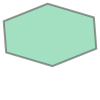

In [39]:
Polygon(h3.h3_to_geo_boundary(h3_idx, geo_json=True))

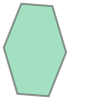

In [40]:
Polygon(h3.h3_to_geo_boundary(h3_idx, geo_json=False))

In [41]:
import folium

def visualize_polygon(polyline, color):
    polyline.append(polyline[0])
    lat = [p[0] for p in polyline]
    lng = [p[1] for p in polyline]
    m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
    m.add_child(my_PolyLine)
    return m

In [42]:
def visualize_hexagons(hexagons, color="red", folium_map=None):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(height=600, width=800, location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
        m.add_child(my_PolyLine)
    return m

In [48]:
h3.h3_get_resolution(h3_idx)

8

In [51]:
h3.h3_to_parent(h3_idx)

'871136a71ffffff'

In [52]:
h3.h3_get_resolution('871136a71ffffff')

7

In [53]:
m = visualize_hexagons(['871136a71ffffff'])
display(m)

In [44]:
geoJson = {'type': 'Polygon',
 'coordinates': [[[37.813318999983238, -122.4089866999972145], [ 37.7866302000007224, -122.3805436999997056 ], [37.7198061999978478, -122.3544736999993603], [ 37.7076131999975672, -122.5123436999983966 ], [37.7835871999971715, -122.5247187000021967],  [37.8151571999998453, -122.4798767000009008]]] }

polyline = geoJson['coordinates'][0]
polyline.append(polyline[0])
lat = [p[0] for p in polyline]
lng = [p[1] for p in polyline]
m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color="green")
m.add_child(my_PolyLine)

hexagons = list(h3.polyfill(geoJson, 8))
polylines = []
lat = []
lng = []
for hex in hexagons:
    polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
    # flatten polygons into loops.
    outlines = [loop for polygon in polygons for loop in polygon]
    polyline = [outline + [outline[0]] for outline in outlines][0]
    lat.extend(map(lambda v:v[0],polyline))
    lng.extend(map(lambda v:v[1],polyline))
    polylines.append(polyline)
for polyline in polylines:
    my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color='red')
    m.add_child(my_PolyLine)
display(m)

In [49]:
                                                                                                
hex_center_coordinates = h3.h3_to_geo(h3_idx) # array of [lat, lng]                                                                                                                  
hex_boundary = h3.h3_to_geo_boundary(h3_idx) # array of arrays of [lat, lng]                                                                                                                                                                                                                                                         
m = visualize_hexagons(list(h3.k_ring_distances(h3_idx, 4)[3]), color="purple")
m = visualize_hexagons(list(h3.k_ring_distances(h3_idx, 4)[2]), color="blue", folium_map=m)
m = visualize_hexagons(list(h3.k_ring_distances(h3_idx, 4)[1]), color="green", folium_map=m)
m = visualize_hexagons(list(h3.k_ring_distances(h3_idx, 4)[0]), color = "red", folium_map=m)
display(m)